In [169]:
import pandas as pd
from IPython.core.pylabtools import figsize
import numpy as np
from matplotlib import pyplot as plt
import pymc as pm
import numpy as np
import seaborn as sns
import scipy.stats as stats

In [170]:
data = pd.read_csv("https://raw.githubusercontent.com/dustywhite7/Econ8310/master/AssignmentData/cookie_cats.csv")

In [171]:
data['retention_1'] = data['retention_1'].replace({True: 1, False: 0})
data['retention_7'] = data['retention_7'].replace({True: 1, False: 0})
data

<ipython-input-171-34c07b765e5e>:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data['retention_1'] = data['retention_1'].replace({True: 1, False: 0})
<ipython-input-171-34c07b765e5e>:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data['retention_7'] = data['retention_7'].replace({True: 1, False: 0})


,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,0,0
1,337,gate_30,38,1,0
2,377,gate_40,165,1,0
3,483,gate_40,1,0,0
4,488,gate_40,179,1,1
...,...,...,...,...,...
90184,9999441,gate_40,97,1,0
90185,9999479,gate_40,30,0,0
90186,9999710,gate_30,28,1,0
90187,9999768,gate_40,51,1,0


In [172]:
gate_30_count = sum(data['version'] == 'gate_30')
gate_40_count = sum(data['version'] == 'gate_40')

gate_30 = data[data['version'] == 'gate_30']['retention_1'].values.astype(int)
gate_40 = data[data['version'] == 'gate_40']['retention_1'].values.astype(int)

print(f"The number of people in gate 30 are: {gate_30_count} \nThe number of people in gate 40 are: {gate_40_count}")

The number of people in gate 30 are: 44700 
The number of people in gate 40 are: 45489


In [173]:
true_p_A = len(data.loc[(data['retention_1'] == 1) & (data['version'] == 'gate_30')])/gate_30_count
true_p_B = len(data.loc[(data['retention_1'] == 1) & (data['version'] == 'gate_40')])/gate_40_count

observations_A = data[data['version'] == 'gate_30']['retention_1']
observations_B = data[data['version'] == 'gate_40']['retention_1']

print(np.mean(data[data['version'] == 'gate_30']['retention_1']))
print(np.mean(data[data['version'] == 'gate_40']['retention_1']))


0.4481879194630872
0.44228274967574577


In [175]:
with pm.Model() as model:
    p_A = pm.Uniform("p_A", 0, 1)
    p_B = pm.Uniform("p_B", 0, 1)

    # Define the deterministic delta function. This is our unknown of interest.
    delta = pm.Deterministic("delta", p_A - p_B)


    # Set of observations, in this case we have two observation datasets.
    obs_A = pm.Bernoulli("obs_A", p_A, observed=observations_A)
    obs_B = pm.Bernoulli("obs_B", p_B, observed=observations_B)

    # To be explained in chapter 3.
    step = pm.Metropolis()
    trace = pm.sample(20000, step=step,chains=2)

Output()

Output()

In [176]:
p_A_samples =  np.concatenate(trace.posterior.p_A.data[:,1000:])
p_B_samples =  np.concatenate(trace.posterior.p_B.data[:,1000:])
delta_samples = np.concatenate(trace.posterior.delta.data[:,1000:])

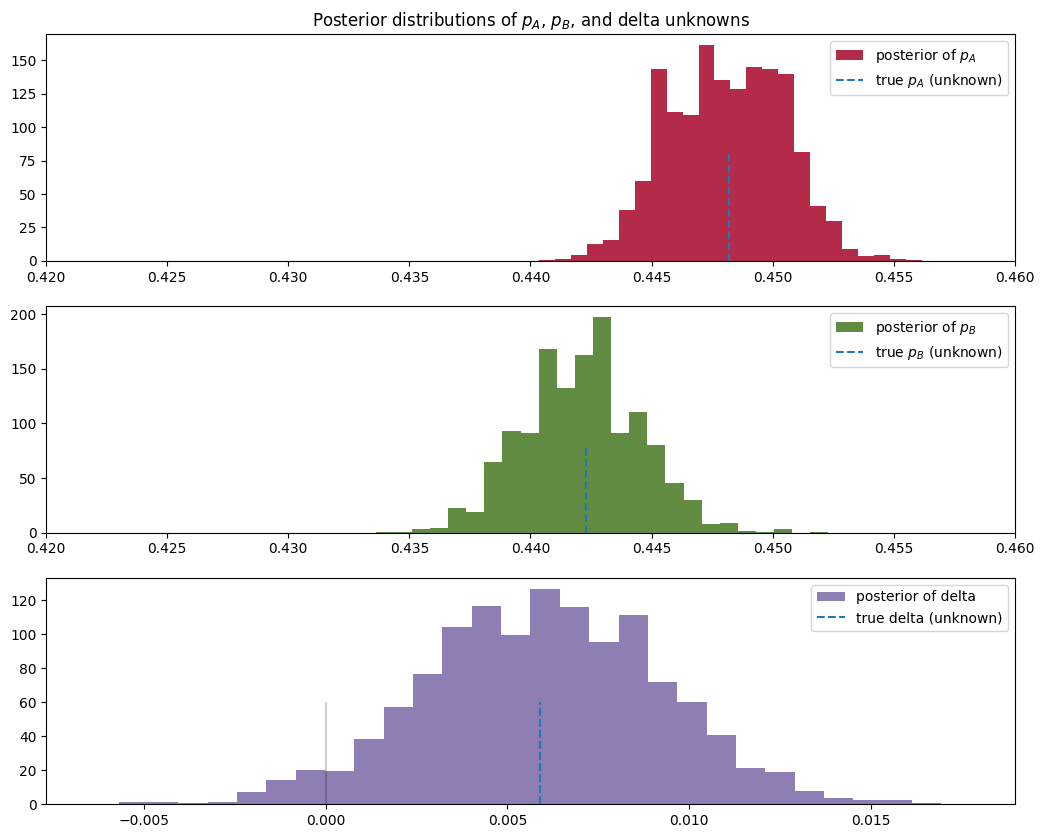

In [179]:
figsize(12.5,10)

#histogram of posteriors

ax = plt.subplot(311)

plt.xlim(0.42, .46)
plt.hist(p_A_samples, histtype='stepfilled', bins=25, alpha=0.85,
         label="posterior of $p_A$", color="#A60628", density=True)
plt.vlines(true_p_A, 0, 80, linestyle="--", label="true $p_A$ (unknown)")
plt.legend(loc="upper right")
plt.title("Posterior distributions of $p_A$, $p_B$, and delta unknowns")

ax = plt.subplot(312)

plt.xlim(0.42, .46)
plt.hist(p_B_samples, histtype='stepfilled', bins=25, alpha=0.85,
         label="posterior of $p_B$", color="#467821", density=True)
plt.vlines(true_p_B, 0, 80, linestyle="--", label="true $p_B$ (unknown)")
plt.legend(loc="upper right")

ax = plt.subplot(313)
plt.hist(delta_samples, histtype='stepfilled', bins=30, alpha=0.85,
         label="posterior of delta", color="#7A68A6", density=True)
plt.vlines(true_p_A - true_p_B, 0, 60, linestyle="--",
          label="true delta (unknown)")
plt.vlines(0, 0, 60, color="black", alpha=0.2)
plt.legend(loc="upper right");

In [180]:
print("Probability site A is WORSE than site B: %.3f" % \
    np.mean(delta_samples < 0))

print("Probability site A is BETTER than site B: %.3f" % \
    np.mean(delta_samples > 0))

Probability site A is WORSE than site B: 0.038
Probability site A is BETTER than site B: 0.962


In [181]:
true_p_A = len(data.loc[(data['retention_7'] == 1) & (data['version'] == 'gate_30')])/gate_30_count
true_p_B = len(data.loc[(data['retention_7'] == 1) & (data['version'] == 'gate_40')])/gate_40_count

observations_A = data[data['version'] == 'gate_30']['retention_7']
observations_B = data[data['version'] == 'gate_40']['retention_7']

print(np.mean(data[data['version'] == 'gate_30']['retention_7']))
print(np.mean(data[data['version'] == 'gate_40']['retention_7']))

0.19020134228187918
0.18200004396667327


In [182]:
with pm.Model() as model:
    p_A = pm.Uniform("p_A", 0, 1)
    p_B = pm.Uniform("p_B", 0, 1)

    # Define the deterministic delta function. This is our unknown of interest.
    delta = pm.Deterministic("delta", p_A - p_B)


    # Set of observations, in this case we have two observation datasets.
    obs_A = pm.Bernoulli("obs_A", p_A, observed=observations_A)
    obs_B = pm.Bernoulli("obs_B", p_B, observed=observations_B)

    # To be explained in chapter 3.
    step = pm.Metropolis()
    trace = pm.sample(20000, step=step,chains=2)

Output()

/usr/local/lib/python3.10/dist-packages/pymc/step_methods/metropolis.py:313: RuntimeWarning: overflow encountered 
in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),

Output()

In [183]:
p_A_samples =  np.concatenate(trace.posterior.p_A.data[:,1000:])
p_B_samples =  np.concatenate(trace.posterior.p_B.data[:,1000:])
delta_samples = np.concatenate(trace.posterior.delta.data[:,1000:])

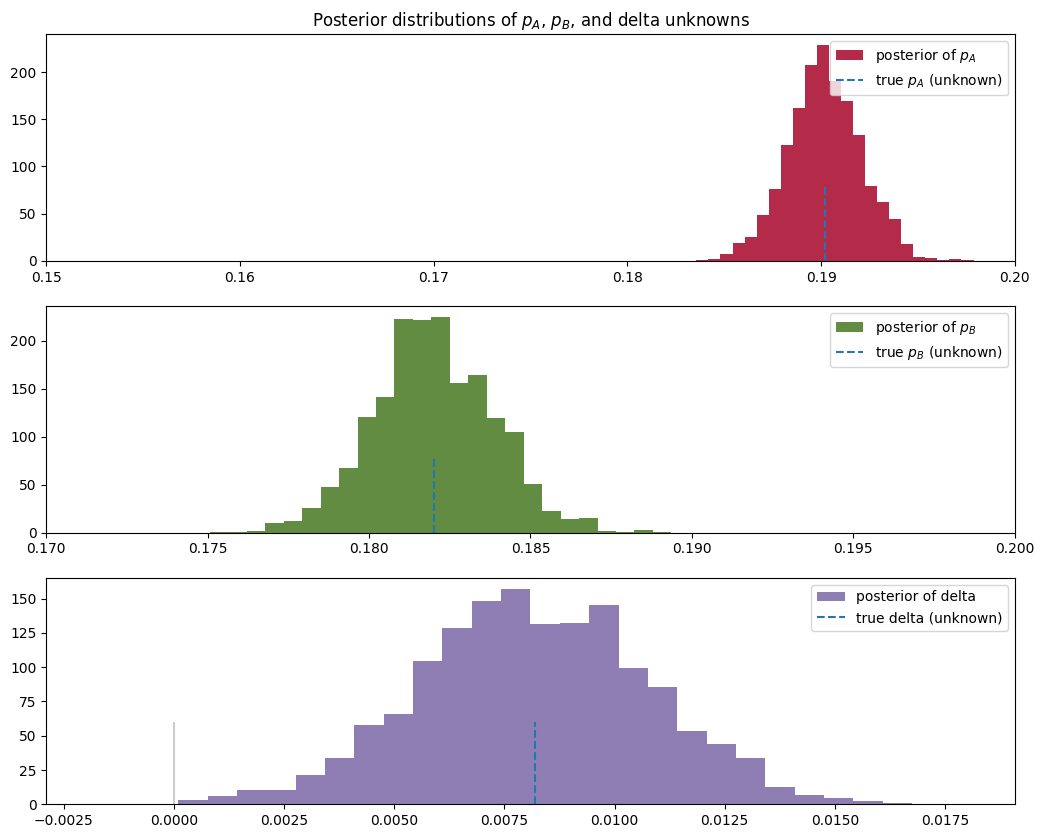

In [184]:
figsize(12.5,10)

#histogram of posteriors

ax = plt.subplot(311)

plt.xlim(0.15, .2)
plt.hist(p_A_samples, histtype='stepfilled', bins=25, alpha=0.85,
         label="posterior of $p_A$", color="#A60628", density=True)
plt.vlines(true_p_A, 0, 80, linestyle="--", label="true $p_A$ (unknown)")
plt.legend(loc="upper right")
plt.title("Posterior distributions of $p_A$, $p_B$, and delta unknowns")

ax = plt.subplot(312)

plt.xlim(0.17, .2)
plt.hist(p_B_samples, histtype='stepfilled', bins=25, alpha=0.85,
         label="posterior of $p_B$", color="#467821", density=True)
plt.vlines(true_p_B, 0, 80, linestyle="--", label="true $p_B$ (unknown)")
plt.legend(loc="upper right")

ax = plt.subplot(313)
plt.hist(delta_samples, histtype='stepfilled', bins=30, alpha=0.85,
         label="posterior of delta", color="#7A68A6", density=True)
plt.vlines(true_p_A - true_p_B, 0, 60, linestyle="--",
          label="true delta (unknown)")
plt.vlines(0, 0, 60, color="black", alpha=0.2)
plt.legend(loc="upper right");

In [185]:
print("Probability site A is WORSE than site B: %.3f" % \
    np.mean(delta_samples < 0))

print("Probability site A is BETTER than site B: %.3f" % \
    np.mean(delta_samples > 0))

Probability site A is WORSE than site B: 0.000
Probability site A is BETTER than site B: 1.000
